# 현재 작업 환경 설정 변경

In [1]:
import os
import sys
os.chdir("/project/ahnailab/jsj0414/지역포함_0113/")
sys.path.append("/home/jsj0414/.conda/envs/image/lib/python3.12/site-packages/")
sys.path.append('./working_path/model/')
#
import mmcv
import torch
# ColonFormer 폴더까지 포함
sys.path.append(os.path.abspath("./working_path/model/original_ColonFormer/"))  

# sys.path.append(os.path.abspath("./working_path/model/"))  

# colon_lib를 올바르게 import
from colon_lib.models.segmentors.colonformer import ColonFormer
print(sys.path)

# from model.config import DEVICE
torch.cuda.set_device(2)  # 메인 파일에서 GPU 2번을 기본 디바이스로 설정
DEVICE = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
print(f"Model is using: {torch.cuda.current_device()}")

/home/jsj0414/.conda/envs/image/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/jsj0414/.conda/envs/image/lib/python3.12/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


['/project/ahnailab/jsj0414/지역포함_0113/working_path', '/project/ahnailab/anaconda3/lib/python312.zip', '/project/ahnailab/anaconda3/lib/python3.12', '/project/ahnailab/anaconda3/lib/python3.12/lib-dynload', '', '/home/jsj0414/.local/lib/python3.12/site-packages', '/project/ahnailab/anaconda3/lib/python3.12/site-packages', '/project/ahnailab/anaconda3/lib/python3.12/site-packages/setuptools/_vendor', '/home/jsj0414/.conda/envs/image/lib/python3.12/site-packages/', './working_path/model/', '/project/ahnailab/jsj0414/지역포함_0113/working_path/model/original_ColonFormer', '/tmp/tmpix1_b3sx']
Model is using: 2


In [2]:
!pwd

/project/ahnailab/jsj0414/지역포함_0113


# 라이브러리 로드

In [3]:
# files and system
import sys
import time
import random
import glob

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
# working with images
import cv2
import imageio
import scipy.ndimage
# import skimage.transform

import torchvision.transforms as transforms

import torchvision
import torch.nn as nn
import torch.nn.functional as F

from tqdm import notebook

# sys.path.insert(0, '..')

# losses
from metrics_loss import *

In [4]:
!pwd

/home/jsj0414


In [5]:
# from DeepLab_V3_p.model import *

In [6]:
def eval_segmentation(outputs: torch.Tensor, labels: torch.Tensor, metric, batch_output=False):
    # outputs가 dict이거나 tuple일 경우, tensor를 가져옴
    if isinstance(outputs, dict):
        outputs = outputs['out']
    elif isinstance(outputs, tuple):
        outputs = outputs[0]

    # sigmoid를 적용하여 예측값을 확률(0~1)로 변환
    # 만약, 모델에 sigmoid나 이에 상응하는 활성화 함수가 포함되어 있으면 아래 줄을 주석 처리할 것
    outputs = torch.sigmoid(outputs)

    # 픽셀 별 예측 값을 0.5를 기준으로 0 또는 1로 thresholding
    outputs = outputs > 0.5

    # binary class의 경우 출력 channel은 1이므로, (BATCH, 1, H, W)의 형식을 가짐
    # 따라서, (BATCH, 1, H, W) -> (BATCH, H, W)로 차원을 줄여줌
    outputs = outputs.squeeze(1).byte()  # (BATCH, 1, H, W) -> (BATCH, H, W)
    labels = labels.squeeze(1).byte()    # (BATCH, 1, H, W) -> (BATCH, H, W)

    # SMOOTH는 나눗셈에서 분모가 0인 것을 방지하기 위해 더해주는 값
    SMOOTH = 1e-8

    if metric == 'iou':
        # IoU : intersection / union
        intersection = (outputs & labels).float().sum((1, 2))  # (BATCH, H, W)에서 픽셀 단위로 AND 연산 후 합산
        union = (outputs | labels).float().sum((1, 2))         # (BATCH, H, W)에서 픽셀 단위로 OR 연산 후 합산
        result = (intersection + SMOOTH) / (union + SMOOTH)
    elif metric == 'dice':
        # Dice Coefficient: 2 * intersection / (output + label)
        intersection = (outputs & labels).float().sum((1, 2))  # (BATCH, H, W)에서 픽셀 단위로 AND 연산 후 합산
        result = (2 * intersection + SMOOTH) / (outputs.float().sum((1, 2)) + labels.float().sum((1, 2)) + SMOOTH)
    elif metric == 'precision':
        # Precision: TP / (TP + FP)
        true_positive = (outputs & labels).float().sum((1, 2))  # True Positive (TP): 예측과 실제가 모두 1인 경우
        predicted_positive = outputs.float().sum((1, 2))        # Predicted Positive: 예측이 1인 경우
        result = (true_positive + SMOOTH) / (predicted_positive + SMOOTH)
    elif metric == 'recall':
        # Recall: TP / (TP + FN)
        true_positive = (outputs & labels).float().sum((1, 2))  # True Positive (TP): 예측과 실제가 모두 1인 경우
        actual_positive = labels.float().sum((1, 2))            # Actual Positive: 실제가 1인 경우
        result = (true_positive + SMOOTH) / (actual_positive + SMOOTH)
    elif metric == 'f1':
        # F1 Score: 2 * (Precision * Recall) / (Precision + Recall)
        true_positive = (outputs & labels).float().sum((1, 2))  # True Positive (TP): 예측과 실제가 모두 1인 경우
        predicted_positive = outputs.float().sum((1, 2))        # Predicted Positive: 예측이 1인 경우
        actual_positive = labels.float().sum((1, 2))            # Actual Positive: 실제가 1인 경우
        # Precision과 Recall 계산
        precision = (true_positive + SMOOTH) / (predicted_positive + SMOOTH)
        recall = (true_positive + SMOOTH) / (actual_positive + SMOOTH)
        # F1 Score 계산
        result = (2 * precision * recall) / (precision + recall + SMOOTH)  

    if batch_output:
        return result  # shape: [BATCH] : 배치 내 각 이미지별 값 (벡터)
    else:
        return result.mean()  # shape: float (단일 상수 값) : 배치 내 모든 이미지의 평균 (상수)

In [7]:
# !nvidia-smi

# 데이터셋 클래스 생성
> 해당 클래스는 이용하려는 이미지와 라벨의 모든 경로(/data/segmentation/...)의 리스트를 인자로 받는다.   

In [8]:
_size = 224, 224
resize = transforms.Resize(_size, interpolation=0)

# set your transforms 
train_transforms = transforms.Compose([
                           transforms.Resize(_size, interpolation=0),
                           transforms.RandomRotation(180),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(_size, padding = 10), # needed after rotation (with original size)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(_size, interpolation=0),
                       ])

# Save images to folder and create a custom dataloader that loads them from their path. More involved than method 1 but allows for greater flexibility
# Requires 3 functions: __init__ to initialize the object, and __len__ and __get__item for pytorch purposes. More functions can be added as needed, but those 3 are necessary for it to function with pytorch
class myDataSet(object):

    def __init__(self, path_images, path_masks, transforms):
        "Initialization"
        self.all_path_images = sorted(path_images)
        self.all_path_masks = sorted(path_masks)
        self.transforms = transforms

    def __len__(self):
        "Returns length of dataset"
        return len(self.all_path_images)  

    def __getitem__(self, index):
        "Return next item of dataset"
        
        if torch.is_tensor(index):        # 인덱스가 tensor 형태일 수 있으니 리스트 형태로 바꿔준다.
            index = index.tolist()
        
        # Define path to current image and corresponding mask
        path_img = self.all_path_images[index]
        path_mask = self.all_path_masks[index]

        # Load image and mask:
        #     .jpeg has 3 channels, channels recorded last
        #     .jpeg records values as intensities from 0 to 255
        #     masks for some reason have values different to 0 or 255: 0, 1, 2, 3, 4, 5, 6, 7, 248, 249, 250, 251, 252, 253, 254, 255
        img_bgr = cv2.imread(path_img) 
        img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)  # cv2는 채널이 BGR로 저장된다 -> 출력할 때 RGB로 바꿔줘야함
        img = img / 255  # 픽셀 값들을 0~1로 변환한다
        
        mask = cv2.imread(path_mask)[:, :, 0] / 255  # 마스크의 채널은 1개만 있으면 된다
        mask = mask.round() # binarize to 0 or 1 (이진분류)
        
        # note, resizing happens inside transforms
        
        # convert to Tensors and fix the dimentions
        img = torch.FloatTensor(np.transpose(img, [2, 0 ,1])) # Pytorch uses the channels in the first dimension
        mask = torch.FloatTensor(mask).unsqueeze(0) # Adding channel dimension to label
        
        # apply transforms/augmentation to both image and mask together
        sample = torch.cat((img, mask), 0) # insures that the same transform is applied
        sample = self.transforms(sample)
        img = sample[:img.shape[0], ...]
        mask = sample[img.shape[0]:, ...]

        return img, mask

In [9]:
# !nvidia-smi

In [10]:
def load_data(data_name, split_ratio, random_seed):
    df = pd.read_csv('/project/ahnailab/jsj0414/지역포함_0113/file_path_change.csv')
    df = pd.DataFrame({col: np.array(df[col]) for col in df.columns})
    
    image_files = list(df[df['type'] == data_name]['images'])
    label_files = list(df[df['type'] == data_name]['labels'])

    if len(split_ratio) == 2:  # split_ratio = (train, test)
        test_size = split_ratio[1] / sum(split_ratio)
        train_images, test_images, train_labels, test_labels = train_test_split(image_files, label_files, test_size=test_size, random_state=random_seed)
        return train_images, test_images, train_labels, test_labels
        
    elif len(split_ratio) == 3:  # split_ratio = (train, validation, test)
        trainval2test_size = split_ratio[2] / sum(split_ratio)
        trainval_images, test_images, trainval_labels, test_labels = train_test_split(image_files, label_files, test_size=trainval2test_size, random_state=random_seed)
        train2val_size = split_ratio[1] / sum(split_ratio[0:2])
        train_images, val_images, train_labels, val_labels = train_test_split(trainval_images, trainval_labels, test_size=train2val_size, random_state=random_seed)
        return train_images, val_images, test_images, train_labels, val_labels, test_labels

In [11]:
# !nvidia-smi

# 모델을 실행시키는데에 추가적으로 필요한 정보

In [12]:
def init_model(model_name):
    model = None  # 기본값을 None으로 설정하여 변수가 초기화되지 않는 상황 방지
    
    if model_name == 'FCBFormer':
        from FCBmodels import FCBFormer
        model = FCBFormer(size=224)
        
    elif model_name == 'EMCADNet':
        from EMCAD import EMCADNet
        model = EMCADNet(encoder='pvt_v2_b2')

    elif model_name == 'ColonSegNet':
        from ColonSegNet import CompNet as ColonSegNet
        model = ColonSegNet()

    elif model_name == 'FCN':
        from FCN.models.segmentation.fcn import fcn_resnet101
        model = fcn_resnet101(num_classes=1)

    elif model_name == 'DeepLab_V3+':
        from DeepLab_V3_p.model import DeepLab as DeepLab_V3_p
        model = DeepLab_V3_p(backbone='resnet', num_classes=1)

    elif model_name == 'ESFPNet':
        from ESFPNet.ESFPmodel import ESFPNetStructure
        model = ESFPNetStructure(embedding_dim=224)


    elif model_name == 'Unet':
        from unet import UNet
        model = UNet(n_channels=3, n_classes=1, pretrained=True)

    elif model_name == 'UNet++':
        from nnunet import Nested_UNet as UNet2p
        model = UNet2p(1, 3)

    elif model_name == 'DuckNet':
        from duck_net import DuckNet
        model = DuckNet(in_channels=3, out_channels=1, depth=5, init_features=34, normalization='batch', interpolation='nearest', out_activation=None, use_multiplier=True)
        import torch.nn as nn
        model.apply(lambda m: nn.init.kaiming_uniform_(m.weight) if type(m) == nn.Conv2d else None) # default init is xaiver uniform        

    elif model_name == 'ColonFormer':
        # sys.path.append("/home/sewoong/me1dimage/model/ColonFormer/colon_lib/") 
        # sys.path.append("./model/original_ColonFormer/colon_lib/models/segmentors/")
        # from colonformer import ColonFormer
        
        backbone=dict(type='mit_b3',style='pythorch')
        
        decode_head=dict(type='UPerHead', in_channels=[64], in_index=[0], channels=128, dropout_ratio=0.1,
                            num_classes=1, norm_cfg=dict(type='BN', requires_grad=True), align_corners=False,decoder_params=dict(embed_dim=768),
                            loss_decode=dict(type='CrossEntropyLoss', use_sigmoid=True, loss_weight=1.0))
        
        
        model = ColonFormer(backbone,decode_head = decode_head,
                        neck=None,
                        auxiliary_head=None,
                        train_cfg=dict(),
                        test_cfg=dict(mode='whole'),
                        pretrained='/project/ahnailab/jsj0414/지역포함_0113/working_path/model/original_ColonFormer/colon_lib/pretrained/mit_b3.pth')

    elif model_name == 'caranet':
        from caranet import caranet
        model = caranet()

    elif model_name == 'FAT_Net':
        from FATNet_model.FAT_Net import FAT_Net
        model = FAT_Net()

    # 모델이 None인 경우, 예외 처리
    if model is None:
        raise ValueError(f"모델 이름 '{model_name}'이 잘못되었거나 모델을 로드할 수 없습니다.")
    
    return model

In [13]:
# !nvidia-smi #,'ColonSegNet'

In [14]:
models = ['ColonFormer','DuckNet','UNet++','Unet' ,'ESFPNet','DeepLab_V3+','FCN'
         ,'ColonSegNet','EMCADNet','FCBFormer','FAT_Net','caranet']
for model in models:
    try: 
        init_model(model)
        print(f'{model} load가능\n')
    except Exception as e:
        print(f'{model} 로드 중 에러발생, 모델 로드 불가: {e}\n')

2025-05-11 14:50:25,857 - mmseg - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: head.weight, head.bias



ColonFormer load가능

DuckNet load가능

UNet++ load가능

Unet load가능

ESFPNet load가능

DeepLab_V3+ 로드 중 에러발생, 모델 로드 불가: No module named 'resnet'

FCN load가능

ColonSegNet load가능



/project/ahnailab/jsj0414/지역포함_0113/working_path/model/EMCAD.py:393: UserWarning: Overwriting pvt_v2_b0 in registry with EMCAD.pvt_v2_b0. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  @register_model
/project/ahnailab/jsj0414/지역포함_0113/working_path/model/EMCAD.py:403: UserWarning: Overwriting pvt_v2_b1 in registry with EMCAD.pvt_v2_b1. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  @register_model
/project/ahnailab/jsj0414/지역포함_0113/working_path/model/EMCAD.py:411: UserWarning: Overwriting pvt_v2_b2 in registry with EMCAD.pvt_v2_b2. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  @register_model
/project/ahnailab/jsj0414/지역포함_0113/working_path/model/EMCAD.py:419: UserWarning: Overwriting pvt_v2_b3 in registry with EMCAD.pvt_v2_b3. This is because the name being registered conflicts wit

Model pvt_v2_b2 backbone:  created, param count: 24849856
Model EMCAD decoder:  created, param count: 1913515
EMCADNet load가능



/project/ahnailab/jsj0414/지역포함_0113/working_path/model/FCBformer/pvt_v2.py:331: UserWarning: Overwriting pvt_v2_b0 in registry with FCBformer.pvt_v2.pvt_v2_b0. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  @register_model
/project/ahnailab/jsj0414/지역포함_0113/working_path/model/FCBformer/pvt_v2.py:342: UserWarning: Overwriting pvt_v2_b1 in registry with FCBformer.pvt_v2.pvt_v2_b1. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  @register_model
/project/ahnailab/jsj0414/지역포함_0113/working_path/model/FCBformer/pvt_v2.py:353: UserWarning: Overwriting pvt_v2_b2 in registry with FCBformer.pvt_v2.pvt_v2_b2. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  @register_model
/project/ahnailab/jsj0414/지역포함_0113/working_path/model/FCBformer/pvt_v2.py:363: UserWarning: Overwriting pvt_v2_b3 in registry 

FCBFormer load가능



/project/ahnailab/jsj0414/지역포함_0113/working_path/model/FATNet_model/FAT_Net.py:62: UserWarning: Overwriting deit_tiny_patch16_224 in registry with FATNet_model.FAT_Net.deit_tiny_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
/project/ahnailab/jsj0414/지역포함_0113/working_path/model/FATNet_model/FAT_Net.py:77: UserWarning: Overwriting deit_small_patch16_224 in registry with FATNet_model.FAT_Net.deit_small_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
/project/ahnailab/jsj0414/지역포함_0113/working_path/model/FATNet_model/FAT_Net.py:92: UserWarning: Overwriting deit_base_patch16_224 in registry with FATNet_model.FAT_Net.deit_base_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
/project/ahnailab/jsj0414/지역포함_0113/working_path/model/FATNet_model/FAT_Net.py:107: Us

FAT_Net load가능

caranet load가능



In [15]:
!pwd

/home/jsj0414


In [15]:
# !nvidia-smi

In [17]:
# !kill -9 8412

In [16]:
def load_loss(loss_name):
    dic_name2func={
           "IoUWithGaussianLoss" : IoUWithGaussianLoss,
        "BCEWithGaussianLoss": BCEWithGaussianLoss,
        "DiceWithGaussianLoss": DiceWithGaussianLoss,
        "FocalWithSSIMLoss": FocalWithSSIMLoss,
        "FocalWithContextualLoss": FocalWithContextualLoss,
        "BCEWithContextualLoss": BCEWithContextualLoss,
        "IoUWithTVLoss_tar": IoUWithTVLoss_tar,
        "DiceWeightedLoss": DiceWeightedLoss,
        "BCEWeightedLoss": BCEWeightedLoss,
        "IoUWeightedLoss": IoUWeightedLoss,
        "FocalWithEdgeLoss": FocalWithEdgeLoss,
        "BCEWithEdgeLoss": BCEWithEdgeLoss,
        "IoUWithTVLoss_tar" : IoUWithTVLoss_tar
        # ,
        
        # 'IoUWithTVLoss' : IoUWithTVLoss,
        # "IoUWithTV_tar_Loss" : IoUWithTV_tar_Loss,
        # "IoUWithSSIMLoss" : IoUWithSSIMLoss,
        # # "BoundaryUncertaintyLoss" : BoundaryUncertaintyLoss,
        # "SpatiallyWeightedLoss" : SpatiallyWeightedLoss,
        # "SaliencyGuidedLoss" : SaliencyGuidedLoss,
        # "IoUWithEdgeLoss" : IoUWithEdgeLoss,
        # "IoUWithContextualLoss" : IoUWithContextualLoss,
        # # "WeightedIoULoss" : WeightedIoULoss,
        # "DiceWithTVLoss_in" : DiceWithTVLoss_in,
        # "DiceWithTVLoss_tar" : DiceWithTVLoss_tar,
        # "MultiScaleDiceLoss" : MultiScaleDiceLoss,
        # "DiceWithContextualLoss" : DiceWithContextualLoss,
        # "DiceWithEdgeLoss" : DiceWithEdgeLoss,
        # "DiceWithSSIMLoss" : DiceWithSSIMLoss,
        # "CRFLoss" : CRFLoss,
        # "FocalWithTVLoss_in" : FocalWithTVLoss_in,
        # "FocalWithTVLoss_tar" : FocalWithTVLoss_tar,
        # "FocalWithRegionWeighting" : FocalWithRegionWeighting,
        # "FocalWithGaussianLoss" : FocalWithGaussianLoss,
        # "BCEWithSSIMLoss" : BCEWithSSIMLoss,
        # "BCEWithTVLoss" : BCEWithTVLoss,
        # "BCEWithTVLoss_tar" : BCEWithTVLoss_tar
    
        # 'IoULoss' : IoULoss,
        # 'DiceLoss' : DiceLoss,
        # 'BCELoss' : BCELoss,
        # 'FocalLoss' : FocalLoss,
        # 'IoUDiceLoss' : IoUDiceLoss,
        # 'IoUBCELoss' : IoUBCELoss,
        # 'IoUFocalLoss' : IoUFocalLoss,
        # 'DiceBCELoss' : DiceBCELoss,
        # 'DiceFocalLoss' : DiceFocalLoss,
        # 'BCEFocalLoss' : BCEFocalLoss,
    }
    return dic_name2func[loss_name]()

# 3. 모델 클래스 생성

In [17]:
def run(data_names,    # e.g. ['breast-cancer-benign']
        model_names,   # e.g. ['FCBFormer']
        loss_names,    # e.g. ['DiceBCELoss']
        iters = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 
        split_ratio = [0.6, 0.2, 0.2],
        base_random_seed = 42, 
        epochs = 200, 
        patience = 50, 
        BATCH_SIZE = 8,
        result_file = None
       ):
    DEVICE = torch.device("cuda:2" if torch.cuda.is_available() else "cpu") # select device for training, i.e. gpu or cpu

    import itertools
    for data_name, model_name, loss_name, iter in itertools.product(data_names, model_names, loss_names, iters):
        if base_random_seed != None:
            random_seed = base_random_seed + iter
            random.seed(random_seed)
            np.random.seed(random_seed)
            torch.manual_seed(random_seed)
            torch.cuda.manual_seed(random_seed)
            torch.backends.cudnn.deterministic = True

        # load data
        train_images, val_images, test_images, train_labels, val_labels, test_labels = load_data(data_name, split_ratio=split_ratio, random_seed=random_seed)

        custom_dataset_train = myDataSet(train_images, train_labels, transforms=test_transforms)
        custom_dataset_val = myDataSet(val_images, val_labels, transforms=test_transforms)
        custom_dataset_test = myDataSet(test_images, test_labels, transforms=test_transforms)
       
        dataloader_train = torch.utils.data.DataLoader(custom_dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
        dataloader_val = torch.utils.data.DataLoader(custom_dataset_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
        dataloader_test = torch.utils.data.DataLoader(custom_dataset_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

        print(f'Experiment env - \n'+
              f'\t - data name : {data_name}\n' +
              f'\t - the  ratio of dataset : total/train/val/test = {sum(split_ratio)}/{split_ratio[0]}/{split_ratio[1]}/{split_ratio[2]}\n' +
              f'\t - the number of dataset : total/train/val/test = {len(custom_dataset_train)+len(custom_dataset_val)+len(custom_dataset_test)}/{len(custom_dataset_train)}/{len(custom_dataset_val)}/{len(custom_dataset_test)}\n' +
              f'\t - model name : {model_name}\n' +
              f'\t - loss name : {loss_name}\n' +
              f'\t - iter : {iter} of {iters}\n' +
              f'\t - random_seed : {random_seed}\n' +
              f'\t - epochs & patience & BATCH_SIZE & DEVICE: {epochs} & {patience} & {BATCH_SIZE} & {DEVICE}')
        
        # initiate model
        model = init_model(model_name)
        model = model.to(DEVICE)

        # load loss
        criterion = load_loss(loss_name)

        # https://github.com/JunMa11/SegLossOdyssey/blob/master/losses_pytorch/hausdorff.py
        
        # Define optimiser
        optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay = 1e-8)                    

        # state to record result
        state = {
            'train_losses' : [], 'train_ious' : [], 'train_dices' : [], 'train_precisions' : [], 'train_recalls' : [], 'train_f1s' : [],
            'val_losses' : [], 'val_ious' : [], 'val_dices' : [], 'val_precisions' : [], 'val_recalls' : [], 'val_f1s' : [],
            'test_losses' : [], 'test_ious' : [], 'test_dices' : [], 'test_precisions' : [], 'test_recalls' : [], 'test_f1s' : [],
            'best_val_dice' : 0,
            'best_val_loss' : np.inf,
            'best_epoch' : 0,
            'best_net' : None,
            'last_epoch' : -1
        }    
        
        for epoch in range(epochs):
            # Train
            model.train()
            train_loss, train_num, train_iou, train_dice, train_precision, train_recall, train_f1 = 0, 0, 0, 0, 0, 0, 0
            for i, (imgs, masks) in enumerate(dataloader_train):
                imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
                
                prediction = model(imgs)

                # dict형태로 데이터가 들어오는 경우가 있음 ######################################################################
                if isinstance(prediction, dict):
                    prediction = torch.Tensor(prediction['out'])
        
                elif isinstance(prediction, tuple):
                    prediction = torch.Tensor(prediction[0])
                
                else:
                    prediction = prediction     
                
                optimizer.zero_grad()
                if loss_name in ["CRFLoss","SaliencyGuidedLoss"]: 
                    loss = criterion(prediction, imgs , masks) 
                else: 
                    loss = criterion(prediction, masks)
                    
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
                train_num += len(imgs)
                train_iou += eval_segmentation(prediction, masks, metric='iou', batch_output=True).sum()
                train_dice += eval_segmentation(prediction, masks, metric='dice', batch_output=True).sum()
                train_precision += eval_segmentation(prediction, masks, metric='precision', batch_output=True).sum()
                train_recall += eval_segmentation(prediction, masks, metric='recall', batch_output=True).sum()
                train_f1 += eval_segmentation(prediction, masks, metric='f1', batch_output=True).sum()
                print("\r Epoch: {} of {}, Iter.: {} of {}, Train Loss: {:.6f}, Train IoU: {:.6f}, Train Dice:  {:.6f}".format(epoch, epochs, i, len(dataloader_train), train_loss/(i+1), train_iou/train_num, train_dice/train_num), end="")

            # compute epoch-overall metric for train
            epoch_train_loss = train_loss/len(dataloader_train)
            epoch_train_iou = (train_iou/train_num).item()
            epoch_train_dice = (train_dice/train_num).item()
            epoch_train_precision = (train_precision/train_num).item()
            epoch_train_recall = (train_recall/train_num).item()
            epoch_train_f1 = (train_f1/train_num).item()
                
            # Validate
            model.eval()
            val_loss, val_num, val_iou, val_dice, val_precision, val_recall, val_f1 = 0, 0, 0, 0, 0, 0, 0
            for i, (imgs, masks) in enumerate(dataloader_val):
                imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
                
                if len(imgs) != BATCH_SIZE:
                    continue                
                    
                prediction = model(imgs)

                # dict형태로 데이터가 들어오는 경우가 있음 ######################################################################
                if isinstance(prediction, dict):
                    prediction = torch.Tensor(prediction['out'])
        
                elif isinstance(prediction, tuple):
                    prediction = torch.Tensor(prediction[0])
                
                else:
                    prediction = prediction    
                
                if loss_name in ["CRFLoss","SaliencyGuidedLoss"]: 
                    loss = criterion(prediction, imgs , masks) 
                else: 
                    loss = criterion(prediction, masks)
                    
                val_loss += loss.item()
                val_num += len(imgs)
                val_iou += eval_segmentation(prediction, masks, metric='iou', batch_output=True).sum()
                val_dice += eval_segmentation(prediction, masks, metric='dice', batch_output=True).sum()
                val_precision += eval_segmentation(prediction, masks, metric='precision', batch_output=True).sum()
                val_recall += eval_segmentation(prediction, masks, metric='recall', batch_output=True).sum()
                val_f1 += eval_segmentation(prediction, masks, metric='f1', batch_output=True).sum()

            # compute epoch-overall metric for val        
            epoch_val_loss = val_loss/len(dataloader_val)
            epoch_val_iou = (val_iou/val_num).item()
            epoch_val_dice = (val_dice/val_num).item()
            epoch_val_precision = (val_precision/val_num).item()
            epoch_val_recall = (val_recall/val_num).item()
            epoch_val_f1 = (val_f1/val_num).item()

            # Test
            model.eval()
            test_loss, test_num, test_iou, test_dice, test_precision, test_recall, test_f1 = 0, 0, 0, 0, 0, 0, 0
            for i, (imgs, masks) in enumerate(dataloader_test):
                imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
                
                if len(imgs) != BATCH_SIZE:
                    continue
                    
                prediction = model(imgs)

                # dict형태로 데이터가 들어오는 경우가 있음 ######################################################################
                if isinstance(prediction, dict):
                    prediction = torch.Tensor(prediction['out'])
        
                elif isinstance(prediction, tuple):
                    prediction = torch.Tensor(prediction[0])
                
                else:
                    prediction = prediction   
                
                
                if loss_name in ["CRFLoss","SaliencyGuidedLoss"] : 
                    loss = criterion(prediction, imgs , masks) 
                else: 
                    loss = criterion(prediction, masks)
                    
                test_loss += loss.item()
                test_num += len(imgs)
                test_iou += eval_segmentation(prediction, masks, metric='iou', batch_output=True).sum()
                test_dice += eval_segmentation(prediction, masks, metric='dice', batch_output=True).sum()
                test_precision += eval_segmentation(prediction, masks, metric='precision', batch_output=True).sum()
                test_recall += eval_segmentation(prediction, masks, metric='recall', batch_output=True).sum()
                test_f1 += eval_segmentation(prediction, masks, metric='f1', batch_output=True).sum()
           
            # compute epoch-overall metric for test
            epoch_test_loss = test_loss/len(dataloader_test)
            epoch_test_iou = (test_iou/test_num).item()
            epoch_test_dice = (test_dice/test_num).item()
            epoch_test_precision = (test_precision/test_num).item()
            epoch_test_recall = (test_recall/test_num).item()
            epoch_test_f1 = (test_f1/test_num).item()

            # print out the result
            print(f"\r Epoch: {epoch} of {epochs}, "+
                  f"Loss: {epoch_train_loss:.4f}/{epoch_val_loss:.4f}/{epoch_test_loss:.4f}, "+
                  f"IoU: {epoch_train_iou:.4f}/{epoch_val_iou:.4f}/{epoch_test_iou:.4f}, "+
                  f"Dice: {epoch_train_dice:.4f}/{epoch_val_dice:.4f}/{epoch_test_dice:.4f}")
            
            # record the result
            state['train_losses'].append(epoch_train_loss)
            state['train_ious'].append(epoch_train_iou)
            state['train_dices'].append(epoch_train_dice)
            state['train_precisions'].append(epoch_train_precision)
            state['train_recalls'].append(epoch_train_recall)
            state['train_f1s'].append(epoch_train_f1)
            state['val_losses'].append(epoch_val_loss)
            state['val_ious'].append(epoch_val_iou)
            state['val_dices'].append(epoch_val_dice)
            state['val_precisions'].append(epoch_val_precision)
            state['val_recalls'].append(epoch_val_recall)
            state['val_f1s'].append(epoch_val_f1)            
            state['test_losses'].append(epoch_test_loss)
            state['test_ious'].append(epoch_test_iou)
            state['test_dices'].append(epoch_test_dice)
            state['test_precisions'].append(epoch_test_precision)
            state['test_recalls'].append(epoch_test_recall)
            state['test_f1s'].append(epoch_test_f1)                
            state['last_epoch'] = epoch
            
            if epoch_val_dice >= state['best_val_dice']:
                print(f'Saving.. {epoch} of {epochs}, best_val_dice improved from {state['best_val_dice']:.4f} to {epoch_val_dice:.4f}')
                state['best_val_dice'] = epoch_val_dice
                state['best_epoch'] = epoch

                # state['best_net'] = model.state_dict()
                # if not os.path.isdir('checkpoints'):
                #     os.mkdir('checkpoints')
                # torch.save(state, f'./checkpoints/ckpt_{model_name}_{data_name}.pth')
            
            elif epoch - state['best_epoch'] > patience:
                print(f"\nEarly stopping. Target criteria has not improved for {patience} epochs.\n")
                break
        
        # print(f'Validationset 기준 \nBest_epoch:{best_epoch_dice}, Best_IOU:{best_iou:.4f}, Best_DiceScore:{best_dice:.4f}')
        
        fig, axs = plt.subplots(nrows=1, ncols=6, figsize=(18, 9))
        for i, metric in enumerate(['losses','ious','dices','precisions','recalls','f1s']):
            axs[i].plot(np.arange(state['last_epoch']+1), state['train_'+metric], label=f'Train, {metric}', linewidth=2, color='blue')
            axs[i].plot(np.arange(state['last_epoch']+1), state['val_'+metric], label=f'Val, {metric}', linewidth=2, color='green')
            axs[i].plot(np.arange(state['last_epoch']+1), state['test_'+metric], label=f'Test, {metric}', linewidth=2, color='orange')

            # best_epoch 시점에 수직선 추가
            axs[i].axvline(x=state['best_epoch'], color='r', linestyle='--', label=f'Best epoch : {state["best_epoch"]}')
            
            # best_epoch에서의 train, val, test 값을 텍스트로 표시
            best_train_value = state['train_' + metric][state['best_epoch']]
            best_val_value = state['val_' + metric][state['best_epoch']]
            best_test_value = state['test_' + metric][state['best_epoch']]
        
            # 각 점에 marker를 찍고 텍스트로 값 표시
            axs[i].scatter(state['best_epoch'], best_train_value, color='blue', zorder=5)
            axs[i].scatter(state['best_epoch'], best_val_value, color='green', zorder=5)
            axs[i].scatter(state['best_epoch'], best_test_value, color='orange', zorder=5)
        
            # 텍스트로 표시
            axs[i].annotate(f'Train: {best_train_value:.4f}', 
                            (state['best_epoch'], best_train_value), 
                            textcoords="offset points", xytext=(0,10), ha='center', color='blue')
            axs[i].annotate(f'Val: {best_val_value:.4f}', 
                            (state['best_epoch'], best_val_value), 
                            textcoords="offset points", xytext=(0,10), ha='center', color='green')
            axs[i].annotate(f'Test: {best_test_value:.4f}', 
                            (state['best_epoch'], best_test_value), 
                            textcoords="offset points", xytext=(0,10), ha='center', color='orange')

            axs[i].set_xlabel('Epoch')
            axs[i].set_ylabel(metric)
            axs[i].set_title(f'{metric}')
            axs[i].legend(loc='best')
        plt.show()
        
        if not os.path.isfile(result_file):
            fp = open(result_file, 'w')
            fp.write(','.join(['data_name',
                           'model_name',
                           'loss_name',
                           'iter',
                           'best_epoch',
                           'test_iou',
                           'test_dice',
                           'test_precision',
                           'test_recall',
                           'test_f1'])+'\n')
        else:
            fp = open(result_file, 'a')
        best_epoch = state['best_epoch']
        fp.write(','.join(map(str, [data_name,
                           model_name,
                           loss_name,
                           iter,
                           best_epoch,
                           state['test_ious'][best_epoch],
                           state['test_dices'][best_epoch],
                           state['test_precisions'][best_epoch],
                           state['test_recalls'][best_epoch],
                           state['test_f1s'][best_epoch]]))+'\n')
        fp.close()

In [18]:
all_losses = [
        "IoUWithGaussianLoss",
        "BCEWithGaussianLoss",
        "DiceWithGaussianLoss",
        "FocalWithSSIMLoss",
        "FocalWithContextualLoss",
        "BCEWithContextualLoss",
        "IoUWithTVLoss_tar", # 해결
        "DiceWeightedLoss", # 해결
        "BCEWeightedLoss",# 헤걀
        "IoUWeightedLoss", # 해
        "FocalWithEdgeLoss", # 해결
        "BCEWithEdgeLoss", # 해결
             #  "IoUWithTV_tar_Loss",
             # "IoUWithSSIMLoss",
             #  "BoundaryUncertaintyLoss",
             #  # "SpatiallyWeightedLoss",
             #  "SaliencyGuidedLoss"
             #    "IoUWithEdgeLoss",
             #    "IoUWithContextualLoss",
             #    "WeightedIoULoss",
             #    "DiceWithTVLoss_in",
             #  "DiceWithTVLoss_tar",
             # "MultiScaleDiceLoss",
             # "DiceWithContextualLoss",
             # "DiceWithEdgeLoss",
             # "DiceWithSSIMLoss",
             # "CRFLoss",
             # "FocalWithTVLoss_in",
             #  "FocalWithTVLoss_tar",
             # "FocalWithGaussianLoss",
             # "FocalWithRegionWeighting",
             # "BCEWithTVLoss",
             #  "BCEWithTVLoss_tar",
             # "BCEWithSSIMLoss"
    # 'IoULoss',
    #     'DiceLoss',
    #     'BCELoss' ,
    #     'FocalLoss',
    #     'IoUDiceLoss',
    #     'IoUBCELoss',
    #     'IoUFocalLoss',
    #     'DiceBCELoss',
    #     'DiceFocalLoss',
    #     'BCEFocalLoss'
]

In [19]:
# data names
data_names = ['CVC-ClinicDB', 'ISIC', 'Kvasir-SEG', 'breast-cancer-benign', 'breast-cancer-malignant', 'wound']

# models name
models = ['ColonFormer','FCN','DuckNet','UNet++','Unet','ESFPNet','DeepLab_V3+','ColonSegNet','EMCADNet','FCBFormer','caranet','FAT_Net'] 

iters = list(np.arange(0,5,1))

In [20]:
        # from nnunet import Nested_UNet as UNet2p
        # model = UNet2p(1, 3)

In [21]:
print(f'data_names: {data_names}')
print(f'models: {models}')
print(f'iters: {iters}')

data_names: ['CVC-ClinicDB', 'ISIC', 'Kvasir-SEG', 'breast-cancer-benign', 'breast-cancer-malignant', 'wound']
models: ['ColonFormer', 'FCN', 'DuckNet', 'UNet++', 'Unet', 'ESFPNet', 'DeepLab_V3+', 'ColonSegNet', 'EMCADNet', 'FCBFormer', 'caranet', 'FAT_Net']
iters: [0, 1, 2, 3, 4]


Experiment env - 
	 - data name : breast-cancer-benign
	 - the  ratio of dataset : total/train/val/test = 1.0/0.6/0.2/0.2
	 - the number of dataset : total/train/val/test = 437/261/88/88
	 - model name : ColonFormer
	 - loss name : BCEWithGaussianLoss
	 - iter : 0 of [0]
	 - random_seed : 42
	 - epochs & patience & BATCH_SIZE & DEVICE: 200 & 40 & 8 & cuda:2


2025-05-11 14:52:19,033 - mmseg - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: head.weight, head.bias



 Epoch: 0 of 200, Loss: 0.7584/0.6937/0.6855, IoU: 0.1288/0.1627/0.1921, Dice: 0.2047/0.2621/0.2922
Saving.. 0 of 200, best_val_dice improved from 0.0000 to 0.2621
 Epoch: 1 of 200, Loss: 0.5899/0.5292/0.5293, IoU: 0.3149/0.4136/0.4018, Dice: 0.4390/0.5275/0.5151
Saving.. 1 of 200, best_val_dice improved from 0.2621 to 0.5275
 Epoch: 2 of 200, Loss: 0.4948/0.4413/0.4511, IoU: 0.4625/0.5024/0.4939, Dice: 0.5850/0.6260/0.6150
Saving.. 2 of 200, best_val_dice improved from 0.5275 to 0.6260
 Epoch: 3 of 200, Loss: 0.4229/0.3663/0.3668, IoU: 0.5131/0.5549/0.5413, Dice: 0.6265/0.6487/0.6370
Saving.. 3 of 200, best_val_dice improved from 0.6260 to 0.6487
 Epoch: 4 of 200, Loss: 0.3675/0.3398/0.3300, IoU: 0.5564/0.5559/0.5478, Dice: 0.6649/0.6537/0.6569
Saving.. 4 of 200, best_val_dice improved from 0.6487 to 0.6537
 Epoch: 5 of 200, Loss: 0.3061/0.3066/0.2969, IoU: 0.5963/0.6044/0.6108, Dice: 0.6963/0.6930/0.7069
Saving.. 5 of 200, best_val_dice improved from 0.6537 to 0.6930
 Epoch: 6 of 200

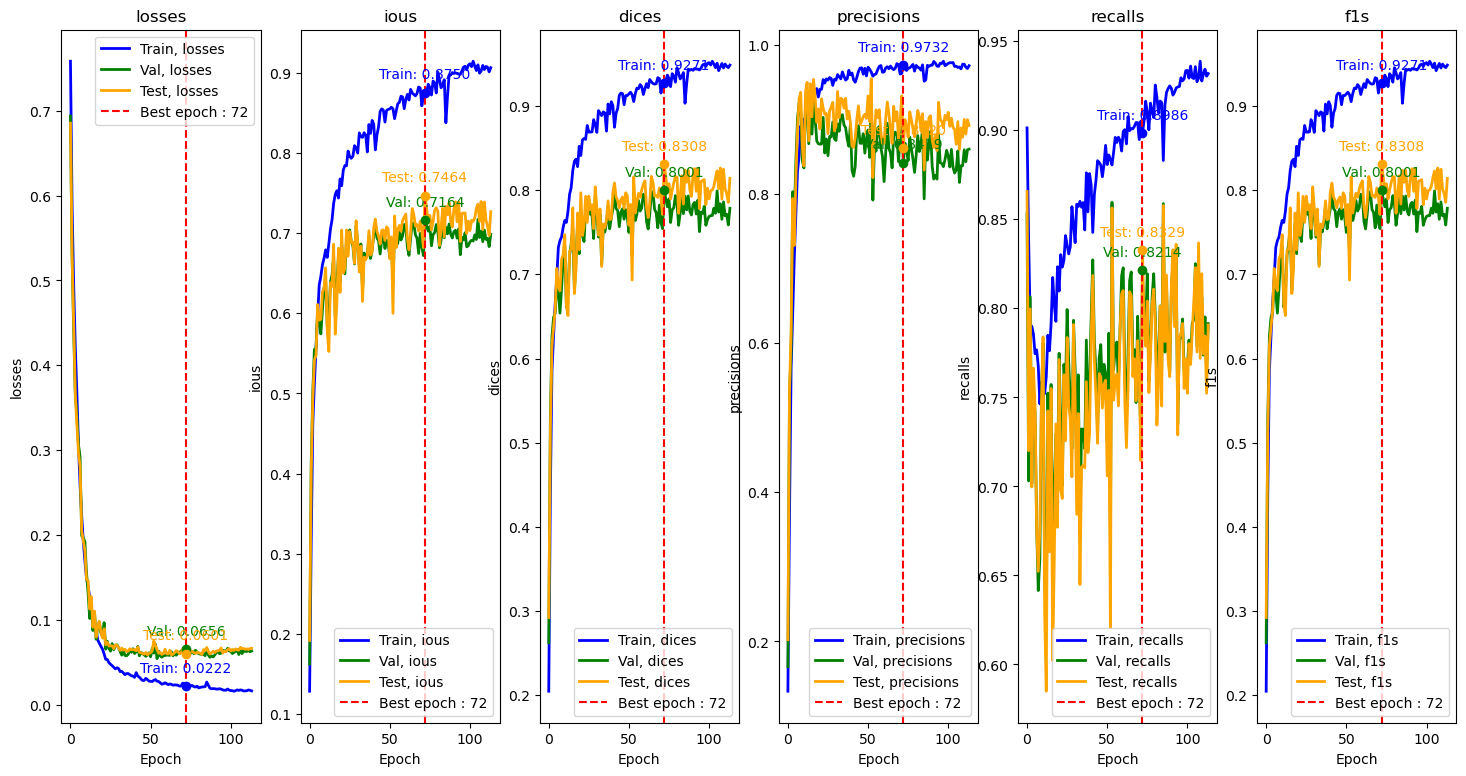

In [22]:
# ['CVC-ClinicDB', 'ISIC', 'Kvasir-SEG', 'breast-cancer-benign', 'breast-cancer-malignant', 'wound']
run_env = {
    'data_names' : ['breast-cancer-benign'],
    'model_names' :["ColonFormer"],
    'loss_names' : ["BCEWithGaussianLoss"], 
    'iters' : [0],
    'split_ratio' : [0.6, 0.2, 0.2], 
    'base_random_seed' : 42,
    'epochs' : 200,
    'patience' : 40,
    'BATCH_SIZE' : 8,
    'result_file' : '/project/ahnailab/jsj0414/지역포함_0113/all_result_analysis/really_jinshim_last_Kvasir_3.csv'
}

run(**run_env)

Experiment env - 
	 - data name : breast-cancer-benign
	 - the  ratio of dataset : total/train/val/test = 1.0/0.6/0.2/0.2
	 - the number of dataset : total/train/val/test = 437/261/88/88
	 - model name : EMCADNet
	 - loss name : BCEWithEdgeLoss
	 - iter : 2 of [2, 3, 4]
	 - random_seed : 44
	 - epochs & patience & BATCH_SIZE & DEVICE: 200 & 40 & 8 & cuda:2
Model pvt_v2_b2 backbone:  created, param count: 24849856
Model EMCAD decoder:  created, param count: 1913515
 Epoch: 0 of 200, Loss: 0.5976/0.4672/0.4677, IoU: 0.1967/0.0000/0.0000, Dice: 0.2964/0.0000/0.0000
Saving.. 0 of 200, best_val_dice improved from 0.0000 to 0.0000
 Epoch: 1 of 200, Loss: 0.4339/0.3868/0.3875, IoU: 0.4532/0.0000/0.0000, Dice: 0.5712/0.0000/0.0000
Saving.. 1 of 200, best_val_dice improved from 0.0000 to 0.0000
 Epoch: 2 of 200, Loss: 0.3447/0.3153/0.4447, IoU: 0.5674/0.5681/0.5841, Dice: 0.6740/0.6740/0.6830
Saving.. 2 of 200, best_val_dice improved from 0.0000 to 0.6740
 Epoch: 3 of 200, Loss: 0.2479/0.3417/0

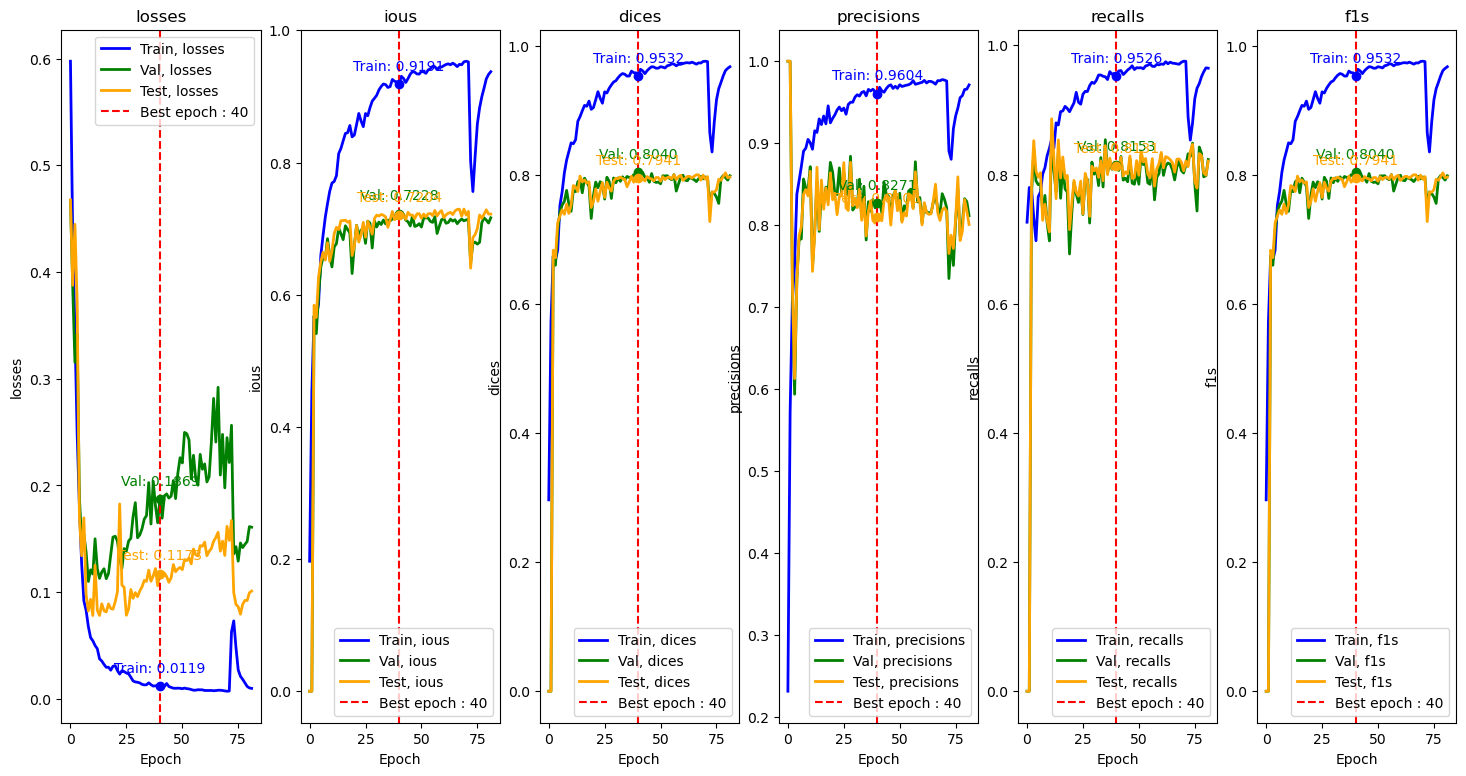

Experiment env - 
	 - data name : breast-cancer-benign
	 - the  ratio of dataset : total/train/val/test = 1.0/0.6/0.2/0.2
	 - the number of dataset : total/train/val/test = 437/261/88/88
	 - model name : EMCADNet
	 - loss name : BCEWithEdgeLoss
	 - iter : 3 of [2, 3, 4]
	 - random_seed : 45
	 - epochs & patience & BATCH_SIZE & DEVICE: 200 & 40 & 8 & cuda:2
Model pvt_v2_b2 backbone:  created, param count: 24849856
Model EMCAD decoder:  created, param count: 1913515
 Epoch: 0 of 200, Loss: 0.6589/0.6279/0.6308, IoU: 0.1482/0.0000/0.0000, Dice: 0.2365/0.0000/0.0000
Saving.. 0 of 200, best_val_dice improved from 0.0000 to 0.0000
 Epoch: 1 of 200, Loss: 0.4864/0.4055/0.4214, IoU: 0.3739/0.0064/0.0006, Dice: 0.4958/0.0110/0.0012
Saving.. 1 of 200, best_val_dice improved from 0.0000 to 0.0110
 Epoch: 2 of 200, Loss: 0.3310/0.3916/0.4170, IoU: 0.4968/0.5021/0.5087, Dice: 0.6044/0.6114/0.6172
Saving.. 2 of 200, best_val_dice improved from 0.0110 to 0.6114
 Epoch: 3 of 200, Loss: 0.2424/0.2602/0

In [ ]:
# ['CVC-ClinicDB', 'ISIC', 'Kvasir-SEG', 'breast-cancer-benign', 'breast-cancer-malignant', 'wound']
run_env = {
    'data_names' : ['breast-cancer-benign'],
    'model_names' :["EMCADNet"],
    'loss_names' : ["BCEWithEdgeLoss"], 
    'iters' : [2,3,4],
    'split_ratio' : [0.6, 0.2, 0.2], 
    'base_random_seed' : 42,
    'epochs' : 200,
    'patience' : 40,
    'BATCH_SIZE' : 8,
    'result_file' : '/project/ahnailab/jsj0414/지역포함_0113/all_result_analysis/really_jinshim_last_Kvasir_3.csv'
}

run(**run_env)

Experiment env - 
	 - data name : Kvasir-SEG
	 - the  ratio of dataset : total/train/val/test = 1.0/0.6/0.2/0.2
	 - the number of dataset : total/train/val/test = 1000/600/200/200
	 - model name : FCN
	 - loss name : IoUWithTVLoss_tar
	 - iter : 3 of [3, 4]
	 - random_seed : 45
	 - epochs & patience & BATCH_SIZE & DEVICE: 200 & 40 & 8 & cuda:2
 Epoch: 0 of 200, Loss: 0.9203/0.9410/0.9130, IoU: 0.5001/0.5742/0.6051, Dice: 0.6315/0.6977/0.7281
Saving.. 0 of 200, best_val_dice improved from 0.0000 to 0.6977
 Epoch: 1 of 200, Loss: 0.9077/0.9383/0.9090, IoU: 0.6779/0.6375/0.6801, Dice: 0.7846/0.7408/0.7824
Saving.. 1 of 200, best_val_dice improved from 0.6977 to 0.7408
 Epoch: 2 of 200, Loss: 0.9037/0.9371/0.9067, IoU: 0.7398/0.6980/0.7459, Dice: 0.8334/0.7932/0.8394
Saving.. 2 of 200, best_val_dice improved from 0.7408 to 0.7932
 Epoch: 3 of 200, Loss: 0.9025/0.9380/0.9066, IoU: 0.7754/0.6227/0.6972, Dice: 0.8593/0.7259/0.7971
 Epoch: 4 of 200, Loss: 0.9001/0.9361/0.9069, IoU: 0.8053/0.73

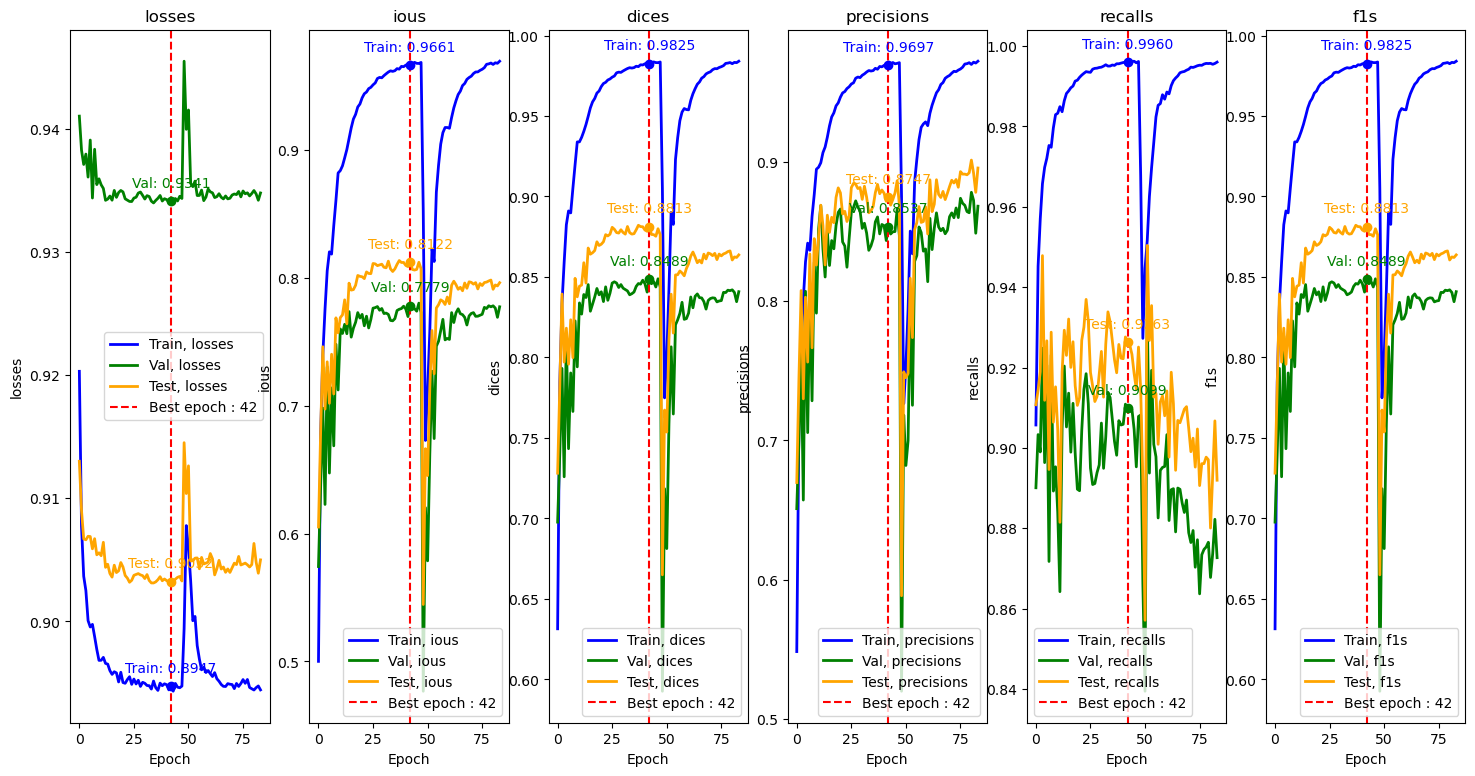

Experiment env - 
	 - data name : Kvasir-SEG
	 - the  ratio of dataset : total/train/val/test = 1.0/0.6/0.2/0.2
	 - the number of dataset : total/train/val/test = 1000/600/200/200
	 - model name : FCN
	 - loss name : IoUWithTVLoss_tar
	 - iter : 4 of [3, 4]
	 - random_seed : 46
	 - epochs & patience & BATCH_SIZE & DEVICE: 200 & 40 & 8 & cuda:2
 Epoch: 0 of 200, Loss: 0.9278/0.9281/0.9052, IoU: 0.4760/0.5967/0.6198, Dice: 0.6097/0.7211/0.7438
Saving.. 0 of 200, best_val_dice improved from 0.0000 to 0.7211
 Epoch: 1 of 200, Loss: 0.9150/0.9239/0.9013, IoU: 0.6647/0.7111/0.7069, Dice: 0.7782/0.8099/0.8029
Saving.. 1 of 200, best_val_dice improved from 0.7211 to 0.8099
 Epoch: 2 of 200, Loss: 0.9102/0.9235/0.9000, IoU: 0.7547/0.7000/0.7052, Dice: 0.8449/0.7950/0.8003
 Epoch: 3 of 200, Loss: 0.9082/0.9257/0.9019, IoU: 0.7743/0.6770/0.7106, Dice: 0.8580/0.7772/0.8052
 Epoch: 4 of 200, Loss: 0.9075/0.9220/0.8973, IoU: 0.7906/0.7323/0.7496, Dice: 0.8709/0.8220/0.8378
Saving.. 4 of 200, best_va

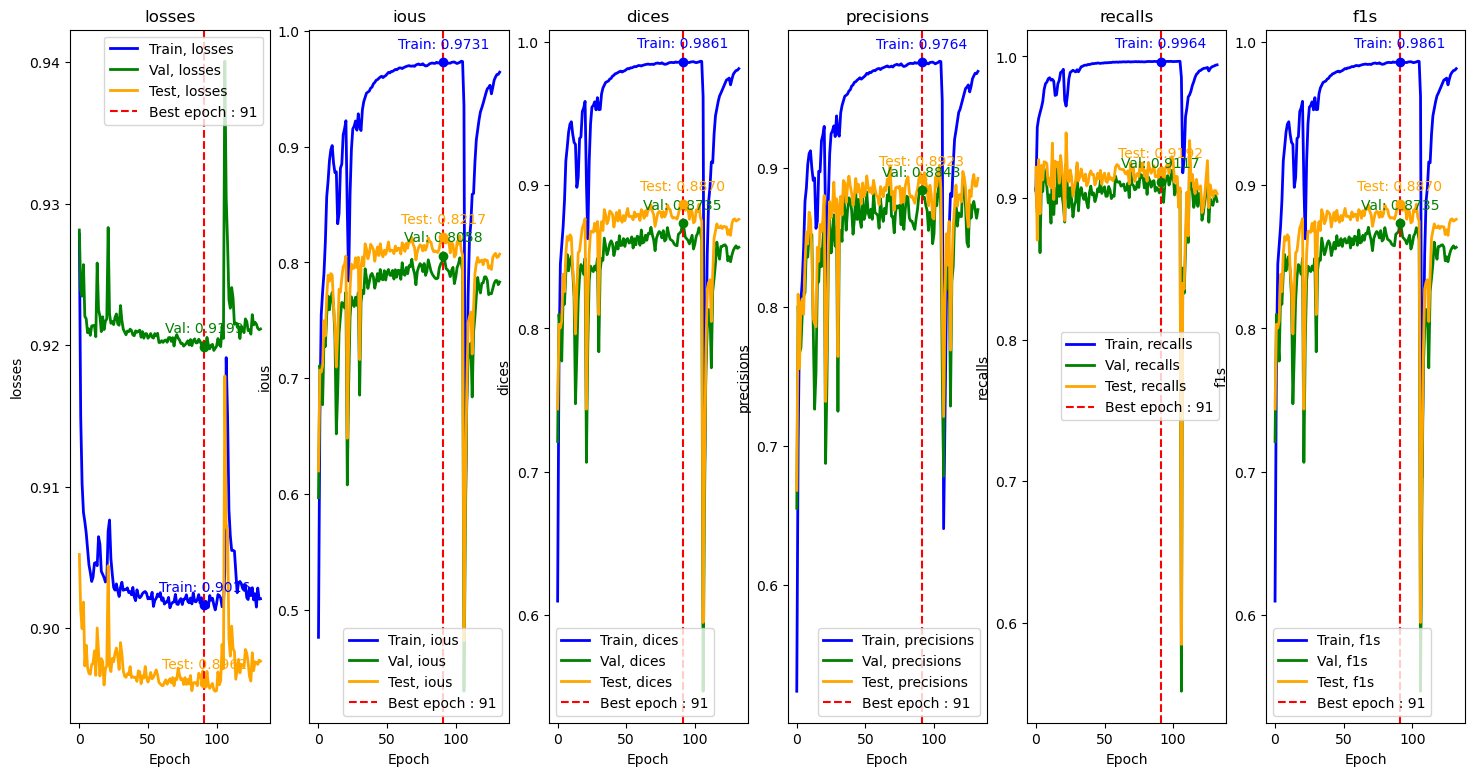

In [24]:
# ['CVC-ClinicDB', 'ISIC', 'Kvasir-SEG', 'breast-cancer-benign', 'breast-cancer-malignant', 'wound']
run_env = {
    'data_names' : ['Kvasir-SEG'],
    'model_names' :["FCN"],
    'loss_names' : ["IoUWithTVLoss_tar"], 
    'iters' : [3,4],
    'split_ratio' : [0.6, 0.2, 0.2], 
    'base_random_seed' : 42,
    'epochs' : 200,
    'patience' : 40,
    'BATCH_SIZE' : 8,
    'result_file' : '/project/ahnailab/jsj0414/지역포함_0113/all_result_analysis/really_jinshim_last_Kvasir_3.csv'
}

run(**run_env)

In [22]:
# ['CVC-ClinicDB', 'ISIC', 'Kvasir-SEG', 'breast-cancer-benign', 'breast-cancer-malignant', 'wound']
run_env = {
    'data_names' : ['breast-cancer-malignant'],
    'model_names' :["Unet"],
    'loss_names' : all_losses, 
    'iters' : [int(it) for it in iters],
    'split_ratio' : [0.6, 0.2, 0.2], 
    'base_random_seed' : 42,
    'epochs' : 200,
    'patience' : 40,
    'BATCH_SIZE' : 8,
    'result_file' : '/home/jsj0414/지역포함_0113/begin200_testing_ground_results.csv'
}

run(**run_env)

Experiment env - 
	 - data name : breast-cancer-malignant
	 - the  ratio of dataset : total/train/val/test = 1.0/0.6/0.2/0.2
	 - the number of dataset : total/train/val/test = 210/126/42/42
	 - model name : Unet
	 - loss name : IoUWithTVLoss
	 - iter : 0 of [0, 1, 2, 3, 4]
	 - random_seed : 42
	 - epochs & patience & BATCH_SIZE & DEVICE: 200 & 40 & 8 & cuda:2
 Epoch: 0 of 200, Loss: 0.8596/0.7278/0.7199, IoU: 0.1742/0.1532/0.1692, Dice: 0.2766/0.2535/0.2718
Saving.. 0 of 200, best_val_dice improved from 0.0000 to 0.2535
 Epoch: 1 of 200, Iter.: 12 of 16, Train Loss: 0.800785, Train IoU: 0.239295, Train Dice:  0.351940

KeyboardInterrupt: 

In [22]:
!nvidia-smi

Mon Feb 24 12:23:28 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100 80GB PCIe          Off | 00000000:2D:00.0 Off |                    0 |
| N/A   60C    P0             305W / 300W |  38016MiB / 81920MiB |     74%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

- 위에 에러는 임의로 코드 실행을 멈춰서 생긴 에러입니다. 신경쓰지 않으셔도 됩니다.